In [1]:
import pandas as pd
import numpy as np
import matplotlib as mp
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import gradio as gr

In [2]:
neighbourhoods =  gpd.read_file("Neighbourhoods - 4326.geojson")
benches = gpd.read_file("Street furniture-Bench data - 4326.geojson")

In [3]:
neighbourhoods.crs
benches.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
neighbourhoods['geometry'] = neighbourhoods['geometry'].to_crs(epsg=32617)
benches['geometry'] = benches['geometry'].to_crs(epsg=32617)

neighbourhoods['centroid'] = neighbourhoods.centroid
benches['centroid'] = benches.centroid
benches = benches[benches['STATUS'] == 'Existing']

<Axes: >

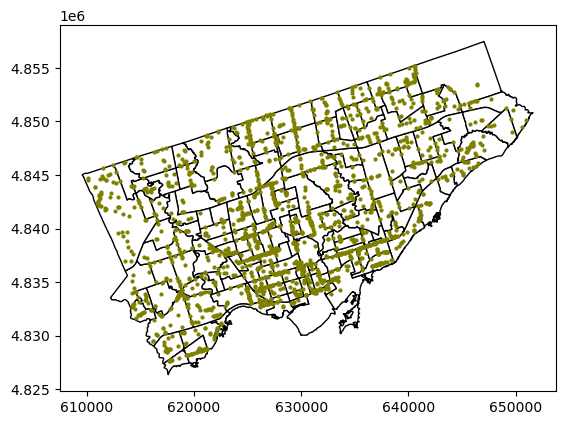

In [15]:
base = neighbourhoods.plot(color='white', edgecolor='black')
benches.plot(ax=base, marker='o', color='olive', markersize=4)

In [17]:
b_within_n = benches.sjoin(neighbourhoods, how = "inner", predicate = "within")
b_intersect_n = benches.sjoin(neighbourhoods, how = "inner", predicate = "intersects")

<Axes: >

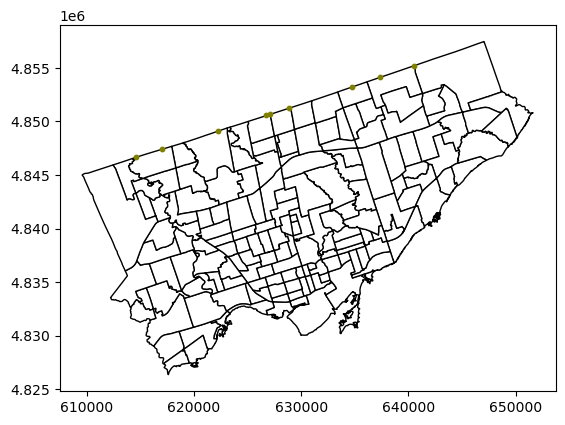

In [19]:
#benches that fall out of neighbourhoods according to "within"

differing_rows_within = pd.concat([b_within_n['geometry'], benches['geometry']]).drop_duplicates(keep=False)
base = neighbourhoods.plot(color='white', edgecolor='black')
differing_rows_within.plot(ax=base, marker='o', color='olive', markersize=10)

<Axes: >

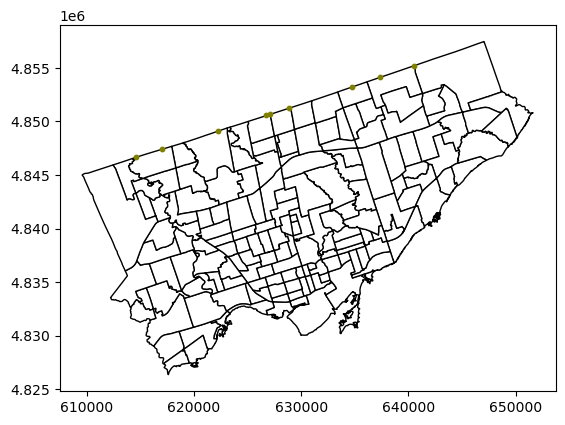

In [21]:
#benches that fall out of neighbourhoods according to "intersect"

differing_rows_int = pd.concat([b_intersect_n['geometry'], benches['geometry']]).drop_duplicates(keep=False)
base = neighbourhoods.plot(color='white', edgecolor='black')
differing_rows_int.plot(ax=base, marker='o', color='olive', markersize=10)

In [27]:
differing_rows_int.equals(differing_rows_within)

outbound_benches = benches[np.isin(benches['geometry'], differing_rows_int)]

<Axes: >

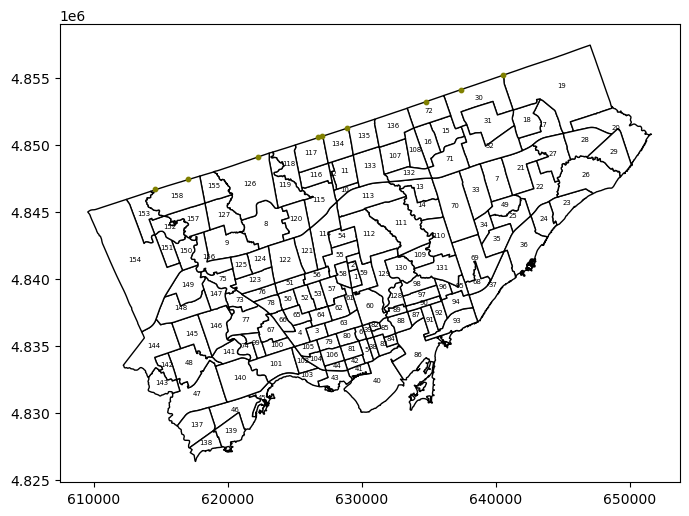

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
outbound_base = neighbourhoods.plot(ax=ax, color='white', edgecolor='black')

for idx, row in neighbourhoods.iterrows():
    centroid = row['centroid']
    ax.annotate(
        f'{row['_id']}',  # Label for centroid
        xy=(centroid.x, centroid.y),  # Centroid position
        ha='center',                  # Horizontal alignment
        fontsize=5,                  # Font size
        color='black'                 # Text color
    )

outbound_benches.plot(ax= outbound_base, marker='o', color='olive', markersize=10)

In [271]:
#Neighbourhoods of interest: 153, 158, 126, 117, 134, 72, 30, 19
#- Proximity Calculations
#- Manually add out of bound benches to the nearest neighbourhood (there is a geopandas function for proximity,but manually check distances)

In [33]:
outbound_benches = outbound_benches.reset_index(drop=True)

for i in range(len(outbound_benches)):
    distances = []
    distances = neighbourhoods.distance(outbound_benches["geometry"][i])
    print(f"{distances.argmin()+1} is the closest neighbourhood to {outbound_benches["_id"][i]} bench")
    

158 is the closest neighbourhood to 33 bench
72 is the closest neighbourhood to 84 bench
30 is the closest neighbourhood to 200 bench
126 is the closest neighbourhood to 227 bench
134 is the closest neighbourhood to 289 bench
30 is the closest neighbourhood to 344 bench
117 is the closest neighbourhood to 725 bench
158 is the closest neighbourhood to 1423 bench
117 is the closest neighbourhood to 1824 bench


In [35]:
nb_list = [158, 72, 30, 126, 134, 30, 117, 158, 117]

outbound_benches['neighbourhood_id\'s'] = nb_list

nb_join = neighbourhoods
nb_join['neighbourhood_id\'s'] = nb_join['_id']

outbound_join = pd.merge(outbound_benches, nb_join, on='neighbourhood_id\'s', how='outer')

ob_bench = outbound_benches['_id']

In [37]:
outbound_join = outbound_join.rename(columns={'_id_x': '_id_left', 
                              'OBJECTID_x': 'OBJECTID_left', 
                              'geometry_x': 'geometry',
                             'centroid_x': 'centroid_left',
                             '_id_y':'_id_right',
                             'OBJECTID_y' : 'OBJECTID_right',
                              'centroid_y': 'centroid_right',
                             'geometry_y': 'geometry_right'})

In [39]:
outbound_join = outbound_join[outbound_join['_id_left'].isin(ob_bench)]
outbound_join.drop(columns=["neighbourhood_id's", 'geometry_right', "centroid_right"], inplace = True)
b_within = b_within_n.drop(columns = ["centroid_right"], inplace = True)

In [41]:
b_nb_join = pd.concat([outbound_join, b_within_n], axis = 0)
b_nb_join = b_nb_join.drop(columns = ['index_right'])

In [43]:
nb_geometry = neighbourhoods[['geometry', '_id', 'centroid']]
nb_geometry = nb_geometry.rename(columns = {"_id": "_id_right",
                                           "geometry": "geometry_right",
                                           "centroid": "centroid_right"})
b_nb_join = pd.merge(b_nb_join, nb_geometry, on = '_id_right', how = 'right')

In [45]:
choropleth_data = b_nb_join.groupby(['geometry_right', 'AREA_LONG_CODE','AREA_NAME', 'centroid_right'], as_index=False).count()

In [47]:
choropleth_data = choropleth_data.rename(columns = {'_id_left' :'Number of Benches'})
choropleth_data = choropleth_data[['geometry_right', 'AREA_LONG_CODE', 'AREA_NAME', 
                                   'centroid_right', 'Number of Benches']]
choropleth_data = choropleth_data.set_geometry('geometry_right')
choropleth_data['Area (m^2)'] = choropleth_data.area
choropleth_data['Bench Density / km^2'] = (choropleth_data[
                                          'Number of Benches'] / choropleth_data['Area (m^2)'] * 1000000)

In [49]:
def render_map():
    geo = "Neighbourhoods - 4326.geojson"
    # Coordinates for Toronto 
    latitude = 43.7
    longitude = -79.42

    # Create a map centered around Toronto
    toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)
    
    popup = folium.GeoJsonPopup(
    fields=["AREA_NAME"],
    aliases=["Neighbourhood"],
    localize=True,
    labels=True,
    style="background-color: white;",
    )
    folium.Choropleth(
    geo_data=geo,
    data = choropleth_data,
    columns=['AREA_LONG_CODE', 'Bench Density / km^2'],  
    key_on='feature.properties.AREA_LONG_CODE',
    fill_color = "RdPu",
    fill_opacity=0.8,
    line_weight=2,
    legend_name = "Benches per Square Km",
    legend_size = '12'
    ).add_to(toronto_map)
    
    folium.GeoJson(data = geo,
               popup = popup,
              style_function=lambda feature: {
                  "fillColor": "#000000",
                  "color": "black",
                  "weight": 1.5,},).add_to(toronto_map)
    return toronto_map._repr_html_()

In [51]:
def bench_num(Neighbourhood):
    return choropleth_data.loc[choropleth_data['AREA_NAME'] == Neighbourhood, 'Number of Benches'].iloc[0]

alphabetical_neighbourhoods = sorted(choropleth_data["AREA_NAME"].tolist())


In [53]:
#address =  gpd.read_file("Address Points - 4326 (1).geojson")
import pickle

#with open('address.pkl', 'wb') as f:
   # pickle.dump(address, f)

with open('address.pkl', 'rb') as f:
    address = pickle.load(f)

In [54]:
#address data as of Nov 30th 3:23 pm
address['geometry'] = address['geometry'].to_crs(epsg=32617)
address['centroid'] = address.centroid

In [55]:
add_num = sorted(list(set((address["ADDRESS_NUMBER"].tolist()))))

In [56]:
add_street = sorted(list(set((address["LINEAR_NAME_FULL"].tolist()))))

In [58]:
def closest_bench(Number, Name):
    filtered_rows = address.loc[(address['ADDRESS_NUMBER'] == Number) & (address['LINEAR_NAME_FULL'] == Name), 'centroid']
    
    if not filtered_rows.empty:
        center = filtered_rows.iloc[0]
        distances = benches["centroid"].distance(center)
        bench_i = distances.idxmin()
        message = f"The closest bench is on {benches['ADDRESSNUMBERTEXT'][bench_i]}, {benches['ADDRESSSTREET'][bench_i]}"
    else:
        message = "The address you have entered is invalid. Please try again."
    return message

In [59]:
#gradio app

with gr.Blocks() as demo:
    gr.Markdown("# BenchedTO")
    gr.Markdown("## Tried after a long day of walking around in the city? Or just looking for a place to sit and take in the city views? Use BenchedTO to find a bench near you!")

 #Nearest Bench    
    with gr.Column():
        gr.Markdown("### Bench Near Me")
        gr.Markdown("Use the dropdown menus to select the street number and street name of a valid address. If the address is valid then you will recieve the address of the closest bench near you.")
        st_num = gr.Dropdown(add_num, label = "Select the street number:")
        st_name = gr.Dropdown(add_street, label = "Select the street name:")
        nearby_bench = gr.Textbox(label = "Nearest bench:")
        
        st_name.change(
            fn = closest_bench,
            inputs = [st_num, st_name],
            outputs = nearby_bench        
        )
        
        st_num.change(
            fn = closest_bench,
            inputs = [st_num, st_name],
            outputs = nearby_bench
        )

    with gr.Column():
        gr.Markdown("### Curious about the state of park benches in the city? Take a look at the map and find out how many benches there are in each neighbourhood!")
    #Map
    with gr.Column():
        gr.Markdown("### Bench Density by Neighbourhood")
        gr.Markdown("This map displays the density of benches in every neighbourhood in the city. \n The colour scale represents the number of benches per square kilometer. Click on a neighbourhood \n to display its name. You can then use the dropdown feature below to find the exact number of benches \n in your neighbourhood of choice.")
        gr.HTML(render_map())

    # Bench Checker
    with gr.Column():
        gr.Markdown("### Bench Checker")
        gr.Markdown("Use the dropdown menu and select a neighbourhood to get the number of benches in the neighbourhood of your choice.")
        neigh_drop = gr.Dropdown(alphabetical_neighbourhoods, label = "Neigbourhoods in the City")
        neigh_drop.change(
            fn = bench_num,
            inputs = neigh_drop,
            outputs = gr.Textbox(label = "Number of benches in the neighbourhood:")
        )
    
demo.launch(share = True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://cab8d809d8300dffca.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
